In [ ]:
import os

try:
    import nucleotide_transformer
except:
    !pip install numpy==1.23.5
    !pip install git+https://github.com/instadeepai/nucleotide-transformer@main |tail -n 1
    import nucleotide_transformer

if "COLAB_TPU_ADDR" in os.environ:
    from jax.tools import colab_tpu

    colab_tpu.setup_tpu()

!pip install -q biopython transformers datasets huggingface_hub accelerate
!pip install lightgbm

import haiku as hk
import jax
import jax.numpy as jnp
from nucleotide_transformer.pretrained import get_pretrained_model

In [ ]:
#@title Select a model
#@markdown ---
model_name = '500M_human_ref'#@param['500M_human_ref', '500M_1000G', '2B5_1000G', '2B5_multi_species', '50M_multi_species_v2', '100M_multi_species_v2', '250M_multi_species_v2', '500M_multi_species_v2']
#@markdown ---

In [ ]:
embeddings_layer = 20  # layer of embeddings extraction (0:24)

# Get pretrained model
parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name=model_name,
    embeddings_layers_to_save=(embeddings_layer,),
    max_positions=999
)
forward_fn = hk.transform(forward_fn)

In [ ]:
from datasets import load_dataset

dataset_dict = load_dataset("proteinea/secondary_structure_prediction")
dataset = dataset_dict["train"]

# dataset = dataset.filter(lambda row: len(row["input"]) % 2 == 0 )  # Filtering to maintain the 2 amino acid per token structure
# dataset = dataset[:2500] # Adjust to available memory

X_amino_acids = dataset["input"]
y_seq = dataset["dssp3"]

In [ ]:
import random

def protein_to_rna(protein_sequence):
    amino_acid_to_codons = {
        "A": ["GCU", "GCC", "GCA", "GCG"],
        "R": ["CGU", "CGC", "CGA", "CGG", "AGA", "AGG"],
        "N": ["AAU", "AAC"],
        "D": ["GAU", "GAC"],
        "B": ["AAU", "AAC", "GAU", "GAC"],
        "C": ["UGU", "UGC"],
        "Q": ["CAA", "CAG"],
        "E": ["GAA", "GAG"],
        "Z": ["CAA", "CAG", "GAA", "GAG"],
        "G": ["GGU", "GGC", "GGA", "GGG"],
        "H": ["CAU", "CAC"],
        "I": ["AUU", "AUC", "AUA"],
        "L": ["CUU", "CUC", "CUA", "CUG", "UUA", "UUG"],
        "K": ["AAA", "AAG"],
        "M": ["AUG"],
        "F": ["UUU", "UUC"],
        "P": ["CCU", "CCC", "CCA", "CCG"],
        "S": ["UCU", "UCC", "UCA", "UCG", "AGU", "AGC"],
        "T": ["ACU", "ACC", "ACA", "ACG"],
        "W": ["UGG"],
        "Y": ["UAU", "UAC"],
        "V": ["GUU", "GUC", "GUA", "GUG"],
        "U": ["UUU"], # Approximation used to maintain the sequence token class structure
        "X": ["UUU"], # added to test code correcteness. TODO delete this row
        "O": ["UUU"] # Same as X
    }

    # Converts protein sequence to RNA sequence
    rna_sequence = ''
    for amino_acid in protein_sequence:
        codons = amino_acid_to_codons.get(amino_acid)
        rna_sequence += codons[random.randint(0, len(codons)-1)]  # Chose codon

    return rna_sequence

In [ ]:
def rna_to_dna(rna_sequence):
    rna_to_dna_base_pairs = {'A': 'T', 'U': 'A', 'C': 'G', 'G': 'C'}

    # Convert RNA sequence to complementary DNA sequence
    dna_sequence = ''.join(rna_to_dna_base_pairs.get(base) for base in rna_sequence)

    return dna_sequence

In [ ]:
batch_size = 8 # Adjust to available memory

def get_6mers_embeddings(sequences: list, batch_size: int):
    embeddings = []  # Stores 6mers embeddings

    # Split sequences into batches
    batched_sequences = [sequences[i:i + batch_size] for i in range(0, len(sequences), batch_size)]

    random_key = jax.random.PRNGKey(0)
    extraction_layer = "embeddings_" + str(embeddings_layer)
    cls_token_position = 0 # Position of the CLS token for every sequence

    for batch in batched_sequences:
        # Tokenize the batch
        tokens_ids = [b[1] for b in tokenizer.batch_tokenize(batch)]
        tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)

        # Infer
        outs = forward_fn.apply(parameters, random_key, tokens)

        # Get embeddings
        batch_embeddings = outs[extraction_layer]

        # Mask for padding tokens
        padding_mask = (tokens != tokenizer.pad_token_id) & (jnp.arange(tokens.shape[1]) != cls_token_position)

        # Element-wise multiplication to set embeddings corresponding to padding tokens to zero
        masked_embeddings = batch_embeddings * padding_mask[:, :, None]

        # Removing embeddings relative to CLS and padding tokens
        sum_embeddings = jnp.sum(masked_embeddings, axis=-1)
        non_zero_mask = sum_embeddings != 0.0
        non_zero_embeddings = masked_embeddings[non_zero_mask]

        embeddings.append(non_zero_embeddings)


    return jnp.concatenate(embeddings, axis=0)

In [ ]:
import math

protein_sequence = X_amino_acids[5]
rna_sequence = protein_to_rna(protein_sequence)
dna_sequence = rna_to_dna(rna_sequence)

n = int(len(dna_sequence)/6)

# Comparing embeddings of a sequenze and the one obtained by removing the last codon

if len(dna_sequence) % 2 == 0:
    embeddings_even  = get_6mers_embeddings([dna_sequence], batch_size)
    embeddings_odd = get_6mers_embeddings([dna_sequence[0:-3]], batch_size)
else:
    embeddings_even  = get_6mers_embeddings([dna_sequence[0:-3]], batch_size)
    embeddings_odd = get_6mers_embeddings([dna_sequence], batch_size)

def calculate_l2_norm(vector):
    # Calculate the L2 norm of the vector
    norm = math.sqrt(sum(x**2 for x in vector))
    return norm

embeddings_odd = embeddings_odd[:n]

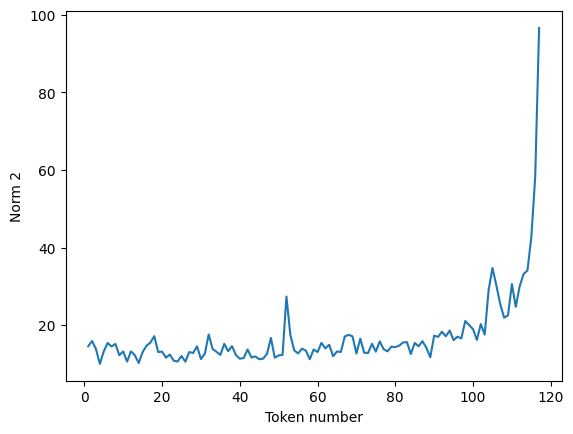

In [ ]:
import matplotlib.pyplot as plt

delta = []
for i in range(n):
    delta.append(calculate_l2_norm(embeddings_even[i] - embeddings_odd[i]))

y = delta
x= range(1, len(delta) + 1)

plt.xlabel('Token number')
plt.ylabel('Norm 2')

plt.plot(x,y)
plt.show()

In [ ]:
import numpy as np

print("Standard deviation:", np.std(delta))

Standard deviation: 10.09471856676676
